In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from functools import reduce
import seaborn as sns
from typing import List

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql import Window
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, lag, lead, avg, count, unix_timestamp
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, Bucketizer
from pyspark.ml.stat import Correlation

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 60000) \
        .set('spark.network.timeout', 60000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Lab_1_var_5") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

directory_path = "data/"

file_list = [file for file in os.listdir(directory_path) if file.endswith(".csv")]

# Чтение файлов и создание DataFrame с явным указанием разделителя
dataframes = [spark.read.csv(os.path.join(directory_path, file), header=True, inferSchema=True, sep=';') for file in file_list]

# Объединение DataFrame в один
merged_dataframe = reduce(DataFrame.union, dataframes)

# Вывод первых строк объединенного DataFrame
merged_dataframe.limit(5).toPandas().head()

,timestamp,site_id,period_id,actual_consumption,actual_pv,load_00,load_01,load_02,load_03,load_04,...,pv_86,pv_87,pv_88,pv_89,pv_90,pv_91,pv_92,pv_93,pv_94,pv_95
0,2014-07-19 18:45:00,1,0,51.625703,22.712489,52.816828,53.501688,54.079161,52.683472,52.590445,...,81.286349,77.580181,58.433449,55.572970,53.792765,51.999028,43.290921,34.161343,28.349901,24.636241
1,2014-07-19 19:30:00,1,0,52.281257,6.618605,51.452796,51.676287,51.329882,51.690879,51.538671,...,55.571058,53.791009,51.997415,43.289440,34.159983,28.348652,24.635094,19.147728,12.982840,7.928666
2,2014-07-19 20:00:00,1,0,50.719565,1.452209,51.313898,52.199835,52.340547,51.844138,52.661063,...,51.996045,43.288181,34.158827,28.347590,24.634119,19.146832,12.982018,7.927911,5.622566,3.299011
3,2014-07-19 20:15:00,1,0,51.901162,0.580877,51.950475,51.624345,50.867434,51.538997,51.331161,...,43.288060,34.158716,28.347489,24.634026,19.146747,12.981939,7.927839,5.622499,3.298950,2.130662
4,2014-07-19 21:00:00,1,0,51.250007,0.000000,52.218820,52.176852,51.745211,51.809854,51.835710,...,24.633942,19.146670,12.981869,7.927774,5.622440,3.298896,2.130612,1.352937,1.246175,1.246205


In [3]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_01: double (nullable = true)
 |-- load_02: double (nullable = true)
 |-- load_03: double (nullable = true)
 |-- load_04: double (nullable = true)
 |-- load_05: double (nullable = true)
 |-- load_06: double (nullable = true)
 |-- load_07: double (nullable = true)
 |-- load_08: double (nullable = true)
 |-- load_09: double (nullable = true)
 |-- load_10: double (nullable = true)
 |-- load_11: double (nullable = true)
 |-- load_12: double (nullable = true)
 |-- load_13: double (nullable = true)
 |-- load_14: double (nullable = true)
 |-- load_15: double (nullable = true)
 |-- load_16: double (nullable = true)
 |-- load_17: double (nullable = true)
 |-- load_18: double (nullable = true)
 |-- load_19: double (nullable = true

Так как столбцы load_XX - показатели прогноза нагрузки потребления за каждые 15 минут, а pv_XX - прогноз произведенного фотоэлектричества на каждые 15 минут, оставим из них каждый девятнадцатый столбец для дальнейшего машинного обучения

In [4]:
merged_dataframe = merged_dataframe.select('timestamp', 'site_id', 'period_id', 
                                           'actual_consumption', 'actual_pv', 
                                           'load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 
                                           'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95')

In [5]:
merged_dataframe.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- site_id: integer (nullable = true)
 |-- period_id: integer (nullable = true)
 |-- actual_consumption: double (nullable = true)
 |-- actual_pv: double (nullable = true)
 |-- load_00: double (nullable = true)
 |-- load_19: double (nullable = true)
 |-- load_38: double (nullable = true)
 |-- load_57: double (nullable = true)
 |-- load_76: double (nullable = true)
 |-- load_95: double (nullable = true)
 |-- pv_00: double (nullable = true)
 |-- pv_19: double (nullable = true)
 |-- pv_38: double (nullable = true)
 |-- pv_57: double (nullable = true)
 |-- pv_76: double (nullable = true)
 |-- pv_95: double (nullable = true)



In [6]:
# Вывод количества строк до удаления пустых значений
merged_dataframe.count()

962282

In [7]:
# Вывод количества уникальных значений
merged_dataframe.agg(*(countDistinct(col(c)).alias(c) for c in merged_dataframe.columns)).show()

+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+
|timestamp|site_id|period_id|actual_consumption|actual_pv|load_00|load_19|load_38|load_57|load_76|load_95| pv_00| pv_19| pv_38| pv_57| pv_76| pv_95|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+
|   160155|     15|      121|            218567|   415202| 935757| 864783| 864544| 862796| 856754| 842483|460535|618002|752992|703847|570111|444074|
+---------+-------+---------+------------------+---------+-------+-------+-------+-------+-------+-------+------+------+------+------+------+------+



In [8]:
# Удаление строк с пропущенными значениями
cleaned_dataframe = merged_dataframe.dropna()

# Вывод количество строк после удаления пустых значений
cleaned_dataframe.count()

962282

In [9]:
# Расчет статистических показателей
statistics_summary = cleaned_dataframe.drop("site_id", "period_id").describe()

# Вывод сводной статистики
statistics_summary.toPandas()

,summary,actual_consumption,actual_pv,load_00,load_19,load_38,load_57,load_76,load_95,pv_00,pv_19,pv_38,pv_57,pv_76,pv_95
0,count,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282,962282
1,mean,84.97831477402406,48.809274108370495,85.00599846857017,85.11734232353224,85.12098540405474,85.10665787305564,85.09318732379766,85.08583470072064,48.49059524394506,48.18818746535695,48.144091795111834,48.15213599298271,48.13404893086863,48.13494419143291
2,stddev,90.95467181105721,106.05339543174318,90.19442371066481,87.79184924918779,87.4837531221951,87.41247729324684,87.41036021718931,87.40504735443703,103.15892191702889,99.08671411903126,98.99168956972771,98.96142357993388,98.94111419031157,98.94536355139381
3,min,0.14690635762456802,0.0,-263.0548926545911,-131.93398864386802,-49.42393083660747,0.2073588179345237,0.2073588179345237,0.2073588179345237,-143.22771168370699,-107.91525627318094,-67.12939769633469,-15.384909359742492,-10.487296129634503,-9.389647857218932
4,max,652.1130937616396,755.3993506760426,971.6318758657195,631.965871140652,605.4697140277374,605.4255633064929,605.4255995641412,605.4255980509118,837.1003312739387,715.6824976092428,715.7096775948107,715.7096701847794,715.7096701768911,715.7096701768845


## Выводы по сводной статистике:



actual_consumption: Среднее значение около 84.98, со стандартным отклонением около 90.95. Минимальное значение 0.15, а максимальное - 652.11. Возможно, это признак потребления энергии с некоторыми выбросами.

actual_pv: Среднее значение около 48.81, со стандартным отклонением около 106.05. Этот признак также представляет собой потребление энергии, с более широким разбросом.

load_00, load_19, load_38, load_57, load_76, load_95: Все эти признаки кажутся похожими, причем у них высокие средние значения и стандартные отклонения, что может свидетельствовать о значительных колебаниях.

pv_00, pv_19, pv_38, pv_57, pv_76, pv_95: Аналогично признакам load, эти признаки также имеют высокие средние значения и стандартные отклонения.

О period_id. Некоторые признаки имеют значительные колебания и могут содержать выбросы, что требует дополнительного анализа и обработки данных перед использованием их в моделировании. аномалии.

In [10]:
from pyspark.sql import functions as F

selected_columns = ['actual_consumption', 'actual_pv', 'load_00']

# Фильтрация выбросов для каждого столбца
for column in selected_columns:
    # Рассчет квартилей
    quartiles = cleaned_dataframe.stat.approxQuantile(column, [0.25, 0.75], 0.0)

    # Рассчет межквартильного размаха
    IQR = quartiles[1] - quartiles[0]

    # Определение границ для определения выбросов
    lower_bound = quartiles[0] - 1.5 * IQR
    upper_bound = quartiles[1] + 1.5 * IQR

    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_before = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_before = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (до)'{column}': Снизу выбросов - {below_quartile_count_before}, Сверху выбросов - {above_quartile_count_before}")

    # Рассчет максимального и минимального значения до фильтрации
    max_value_before = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_before = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы до фильтрации
    median_value_before = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (до) '{column}': Максимальное значение - {max_value_before}, Минимальное значение - {min_value_before}, Медиана - {median_value_before}")

    # Фильтрация данных
    cleaned_dataframe = cleaned_dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    # Фильтрация данных и подсчет значений ниже и выше усов
    below_quartile_count_after = cleaned_dataframe.filter(col(column) < lower_bound).count()
    above_quartile_count_after = cleaned_dataframe.filter(col(column) > upper_bound).count()

    print(f"Столбец (после)'{column}': Снизу выбросов - {below_quartile_count_after}, Сверху выбросов - {above_quartile_count_after}")

    # Рассчет максимального и минимального значения после фильтрации
    max_value_after = cleaned_dataframe.agg(F.max(col(column))).collect()[0][0]
    min_value_after = cleaned_dataframe.agg(F.min(col(column))).collect()[0][0]

    # Рассчет медианы после фильтрации
    median_value_after = cleaned_dataframe.approxQuantile(column, [0.5], 0.0)[0]
    print(f"Столбец (после) '{column}': Максимальное значение - {max_value_after}, Минимальное значение - {min_value_after}, Медиана - {median_value_after}")


Столбец (до)'actual_consumption': Снизу выбросов - 0, Сверху выбросов - 25032
Столбец (до) 'actual_consumption': Максимальное значение - 652.1130937616396, Минимальное значение - 0.14690635762456802, Медиана - 67.38844704635197
Столбец (после)'actual_consumption': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'actual_consumption': Максимальное значение - 296.30518566316505, Минимальное значение - 0.14690635762456802, Медиана - 61.70379391766973
Столбец (до)'actual_pv': Снизу выбросов - 0, Сверху выбросов - 160280
Столбец (до) 'actual_pv': Максимальное значение - 755.3993506760426, Минимальное значение - 0.0, Медиана - 0.0
Столбец (после)'actual_pv': Снизу выбросов - 0, Сверху выбросов - 0
Столбец (после) 'actual_pv': Максимальное значение - 75.9453319472611, Минимальное значение - 0.0, Медиана - 0.0
Столбец (до)'load_00': Снизу выбросов - 15, Сверху выбросов - 11745
Столбец (до) 'load_00': Максимальное значение - 658.4492607170723, Минимальное значение - -263.0548926545911, М

Гистограммы распределения количественных признаков

<BarContainer object of 17 artists>

Text(0.5, 1.0, 'Distribution of actual_consumption')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

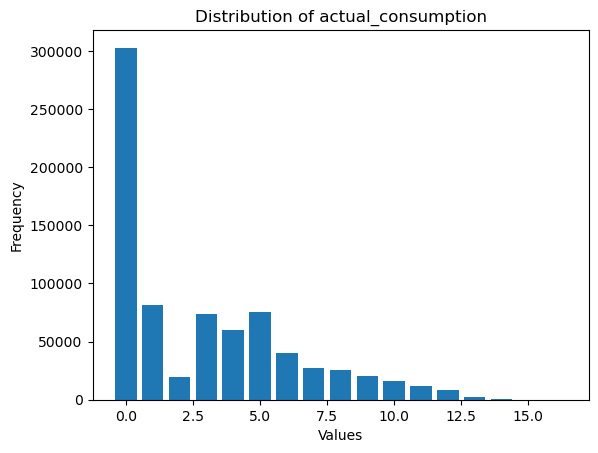

<BarContainer object of 5 artists>

Text(0.5, 1.0, 'Distribution of actual_pv')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

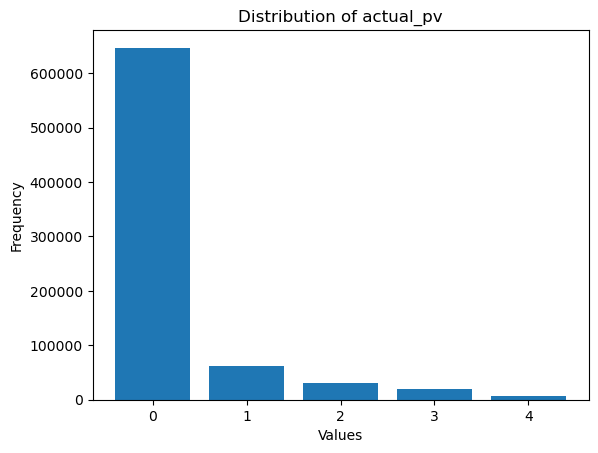

<BarContainer object of 14 artists>

Text(0.5, 1.0, 'Distribution of load_00')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

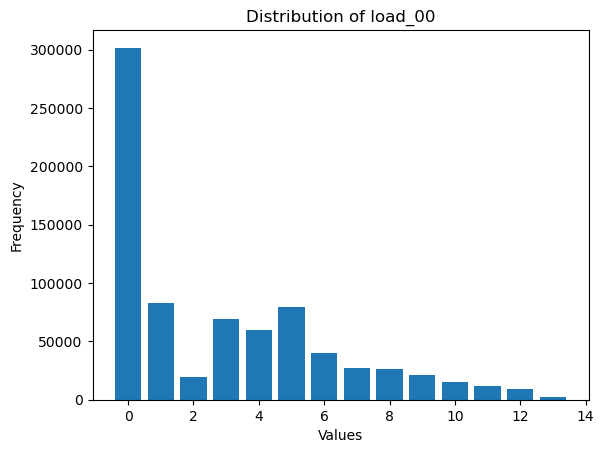

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of load_95')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

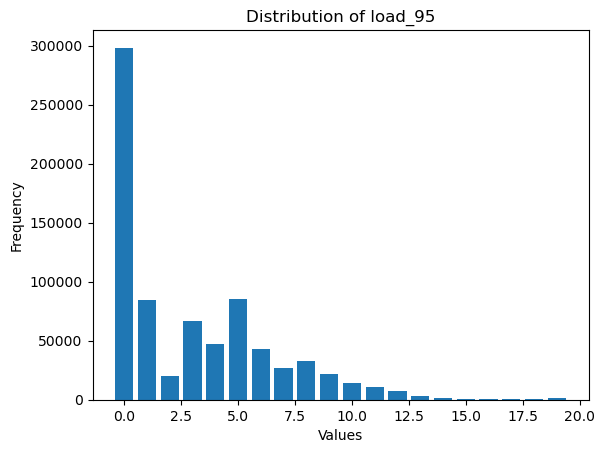

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of pv_00')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

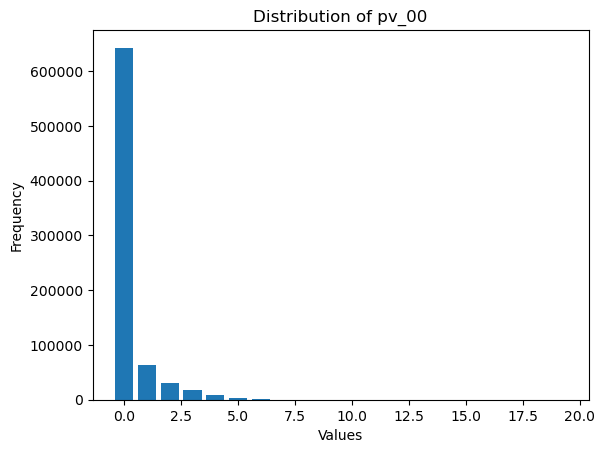

<BarContainer object of 20 artists>

Text(0.5, 1.0, 'Distribution of pv_95')

Text(0.5, 0, 'Values')

Text(0, 0.5, 'Frequency')

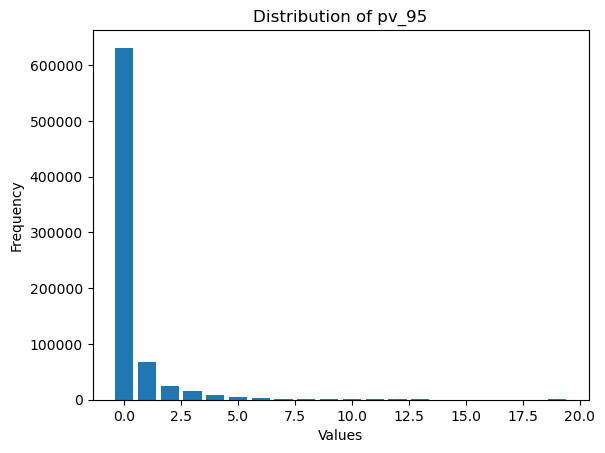

In [11]:
selected_features = ['actual_consumption', 'actual_pv', 'load_00', 'load_95', 'pv_00', 'pv_95'] 

num_buckets = 20
step = 350 / num_buckets
splits = [float("-inf")] + [i * step for i in range(1, num_buckets)] + [float("inf")]
# Построение гистограммы для каждой колонки
for selected_column in selected_features:
    bucketizer = Bucketizer(splits=splits, inputCol=selected_column, outputCol="bucketizer")
    df_bucket = bucketizer.transform(cleaned_dataframe)
    bucket_counts = df_bucket.groupBy("bucketizer").count().orderBy("bucketizer")
    bucket_counts_pd = bucket_counts.toPandas()
    plt.bar(bucket_counts_pd["bucketizer"], bucket_counts_pd["count"], align="center", label=selected_column)
    plt.title(f"Distribution of {selected_column}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

Гистограммы распределения категориальных признаков

<BarContainer object of 15 artists>

Text(0.5, 1.0, 'Distribution of site_id')

Text(0.5, 0, 'site_id')

Text(0, 0.5, 'Count')

<BarContainer object of 121 artists>

Text(0.5, 1.0, 'Distribution of period_id')

Text(0.5, 0, 'period_id')

Text(0, 0.5, 'Count')

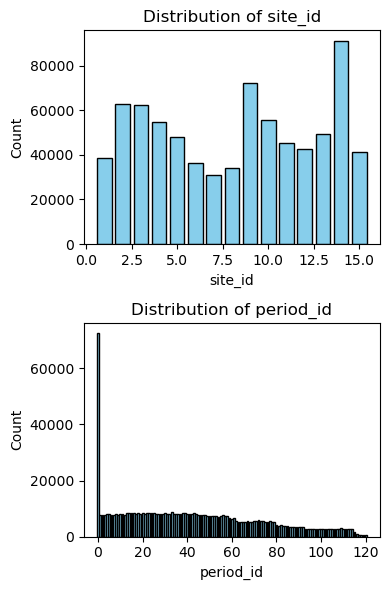

In [12]:
selected_features = ['site_id', 'period_id'] 

fig, axs = plt.subplots(len(selected_features), 1, figsize=(4, 3 * len(selected_features)))

# Построение гистограмм для каждого выбранного признака
for i, feature in enumerate(selected_features):
    # Сгруппировать по признаку и подсчитать количество
    data_grouped = cleaned_dataframe.groupBy(feature).count().collect()
    # Извлечение данных для построения графика
    categories = [row[0] for row in data_grouped]
    counts = [row[1] for row in data_grouped]
    axs[i].bar(categories, counts, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Count')

# Регулировка расположения подграфиков
plt.tight_layout()

# Отображение графика
plt.show()

In [13]:
# Создаем VectorAssembler для объединения признаков в один вектор
feature_cols = ['load_00', 'load_19', 'load_38', 'load_57', 'load_76', 'load_95', 'pv_00', 'pv_19', 'pv_38', 'pv_57', 'pv_76', 'pv_95']  
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Применяем VectorAssembler к данным
data = vector_assembler.transform(cleaned_dataframe)

# Вычисляем матрицу корреляции
correlation_matrix = Correlation.corr(data, "features").head()
correlation_array = correlation_matrix[0].toArray()

# Выводим матрицу корреляции
correlation_df = pd.DataFrame(correlation_array, columns=feature_cols)

In [14]:
correlation_df.corr()

,load_00,load_19,load_38,load_57,load_76,load_95,pv_00,pv_19,pv_38,pv_57,pv_76,pv_95
load_00,1.000000,0.812681,0.765678,0.797396,0.857775,0.985670,-0.340879,0.095751,0.280596,0.333863,0.205118,-0.289084
load_19,0.812681,1.000000,0.915116,0.693086,0.586694,0.773557,-0.496317,0.462635,0.695566,0.209941,-0.226220,-0.515323
load_38,0.765678,0.915116,1.000000,0.877485,0.723081,0.739161,-0.696616,0.202184,0.712851,0.524092,-0.042390,-0.682137
load_57,0.797396,0.693086,0.877485,1.000000,0.942938,0.800745,-0.703184,-0.184366,0.410194,0.744007,0.384720,-0.617562
load_76,0.857775,0.586694,0.723081,0.942938,1.000000,0.877728,-0.532872,-0.284985,0.165420,0.668116,0.545017,-0.416940
load_95,0.985670,0.773557,0.739161,0.800745,0.877728,1.000000,-0.328789,0.069473,0.250542,0.340928,0.234318,-0.267776
pv_00,-0.340879,-0.496317,-0.696616,-0.703184,-0.532872,-0.328789,1.000000,0.028598,-0.671101,-0.782225,-0.237496,0.909074
pv_19,0.095751,0.462635,0.202184,-0.184366,-0.284985,0.069473,0.028598,1.000000,0.540892,-0.568520,-0.783322,-0.138008
pv_38,0.280596,0.695566,0.712851,0.410194,0.165420,0.250542,-0.671101,0.540892,1.000000,0.250240,-0.521383,-0.742135
pv_57,0.333863,0.209941,0.524092,0.744007,0.668116,0.340928,-0.782225,-0.568520,0.250240,1.000000,0.584966,-0.679897


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Матрица корреляции признаков')

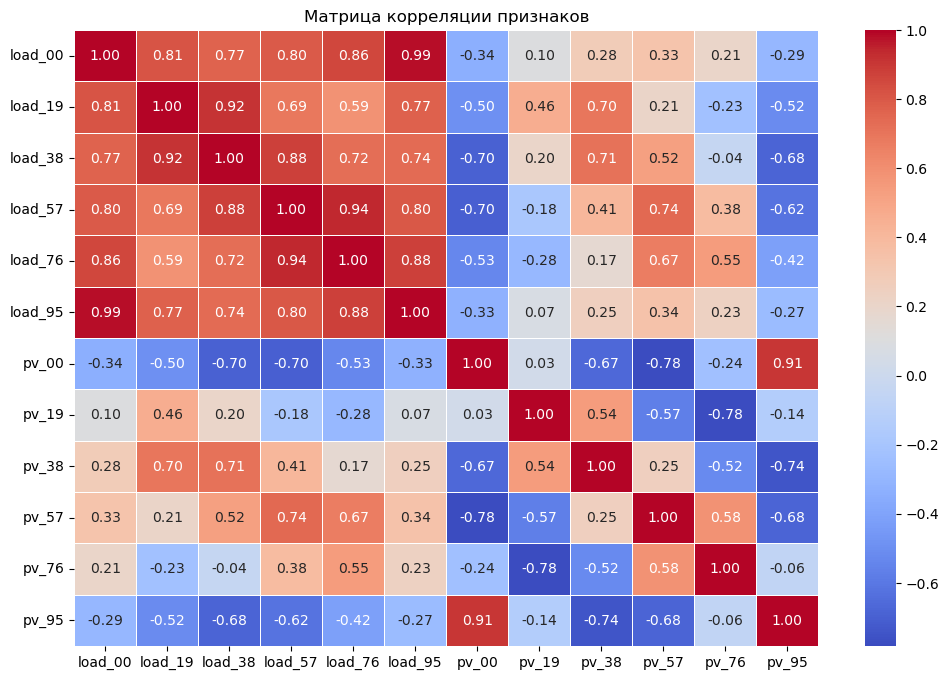

In [15]:
# Строим тепловую карту корреляции с использованием Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Матрица корреляции признаков')
plt.show()

In [16]:
# Сохраним преобразованный датафрейм в csv-файл.
cleaned_dataframe.coalesce(1).write.options(header='True', delimiter=';').csv('filtered_data/data')

# Закрываем сессию Spark
spark.stop()